# 🎯 Train XGBoost on Drug Response Using scFoundation Embeddings

This notebook uses only the scFoundation PCA features (e.g., `SCF_PC1` to `SCF_PC30`) as input to train XGBoost regressors per drug and evaluate their performance using cross-validation.


In [1]:
import os
import numpy as np
import pandas as pd
from xgboost import XGBRegressor
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import make_scorer, root_mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns


## 📥 Configuration and Dataset Loading


In [2]:
NUM_PCS = 30  # set this to match your PCA output
DATA_PATH = f"../../data/bulk/bulk_with_scfoundation_pca_top{NUM_PCS}.parquet"

data = pd.read_parquet(DATA_PATH)
print("✅ Dataset loaded:", data.shape)


✅ Dataset loaded: (571985, 53)


In [3]:
os.makedirs("results/xgboost", exist_ok=True)

non_features = ["SANGER_MODEL_ID", "DRUG_ID", "LN_IC50"]
#feature_cols = [col for col in data.columns if col.startswith("SCF_PC")]
feature_cols = [col for col in data.columns if col not in non_features]


kf = KFold(n_splits=5, shuffle=True, random_state=42)
rmse_scorer = make_scorer(root_mean_squared_error, greater_is_better=False)


## 🚀 Train XGBoost Regressor per Drug with Cross-Validation


In [4]:
results = []

for drug_id in sorted(data["DRUG_ID"].unique()):
    df = data[data["DRUG_ID"] == drug_id].dropna(subset=["LN_IC50"])
    if df.shape[0] < 10:
        continue

    X = df[feature_cols].values
    y = df["LN_IC50"].values

    model = XGBRegressor(
        n_estimators=100,
        max_depth=4,
        learning_rate=0.1,
        subsample=0.9,
        colsample_bytree=0.8,
        random_state=42,
        n_jobs=-1
    )
    model.fit(X, y)

    rmse_scores = cross_val_score(model, X, y, scoring=rmse_scorer, cv=kf)
    r2_scores = cross_val_score(model, X, y, scoring="r2", cv=kf)

    results.append({
        "DRUG_ID": drug_id,
        "n_samples": len(df),
        "rmse_mean": -rmse_scores.mean(),
        "rmse_std": rmse_scores.std(),
        "r2_mean": r2_scores.mean(),
        "r2_std": r2_scores.std()
    })


## 💾 Save and Preview Results


In [5]:
results_df = pd.DataFrame(results)
results_df.to_csv(f"results/xgboost/xgb_results_scf_only_{NUM_PCS}_pcs.csv", index=False)

print(f"📁 Saved to results/xgboost/xgb_results_scf_only_{NUM_PCS}_pcs.csv")
results_df.head()


📁 Saved to results/xgboost/xgb_results_scf_only_30_pcs.csv


,DRUG_ID,n_samples,rmse_mean,rmse_std,r2_mean,r2_std
0,1,391,1.087422,0.180278,0.012059,0.111533
1,3,356,2.069385,0.176787,-0.093877,0.102755
2,5,394,1.540966,0.117018,0.117540,0.120507
3,6,403,0.940904,0.087074,-0.132045,0.039799
4,9,396,1.438657,0.130681,0.014964,0.107947


## 📊 Visualize Performance Across Drugs


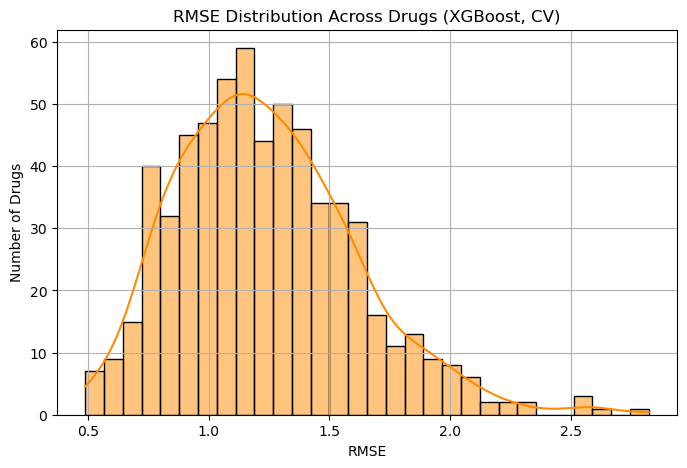

In [6]:
plt.figure(figsize=(8, 5))
sns.histplot(results_df["rmse_mean"], kde=True, bins=30, color="darkorange")
plt.title("RMSE Distribution Across Drugs (XGBoost, CV)")
plt.xlabel("RMSE")
plt.ylabel("Number of Drugs")
plt.grid(True)
plt.savefig(f"results/xgboost/xgb_rmse_scf_only_{NUM_PCS}_pcs.png", dpi=300)
plt.show()
plt.close()


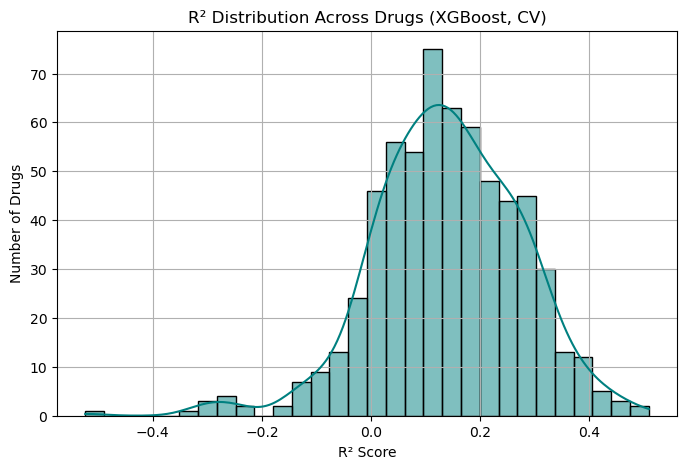

In [7]:
plt.figure(figsize=(8, 5))
sns.histplot(results_df["r2_mean"], kde=True, bins=30, color="teal")
plt.title("R² Distribution Across Drugs (XGBoost, CV)")
plt.xlabel("R² Score")
plt.ylabel("Number of Drugs")
plt.grid(True)
plt.savefig(f"results/xgboost/xgb_r2_scf_only_{NUM_PCS}_pcs.png", dpi=300)
plt.show()
plt.close()
